In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector

In [2]:
mmirs = WFSFactory(wfs="mmirs", nzern=20, pup_size=335)

<IPython.core.display.Javascript object>


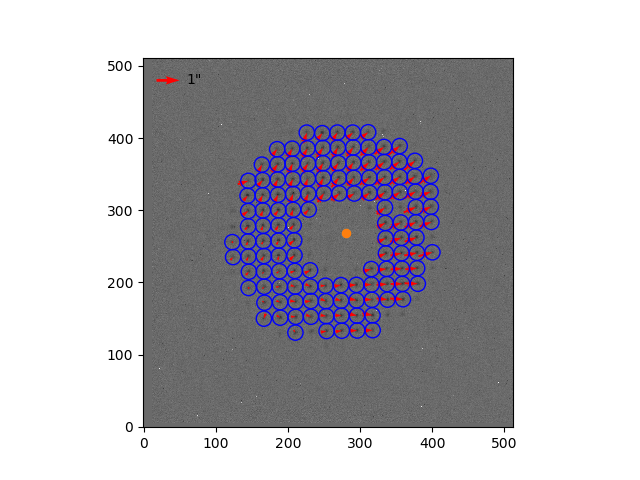

In [16]:
mmirs_file = "/Users/tim/MMT/wfsdat/20170405/rawdata/mmirs_wfs_0185.fits"
results = mmirs.measure_slopes(mmirs_file, 'mmirs1', plot=True)
plt.show()

Fringe Coefficients
 Z02: -4.24e+03 nm 	 X Tilt (1, 1)
 Z03: -2.73e+03 nm 	 Y Tilt (1, -1)
 Z04:      -941 nm 	 Defocus (2, 0)
 Z05:     -5.73 nm 	 Primary Astig at 45˚ (2, -2)
 Z06:       222 nm 	 Primary Astig at 0˚ (2, 2)
 Z07:      33.9 nm 	 Primary Y Coma (3, -1)
 Z08:       253 nm 	 Primary X Coma (3, 1)
 Z09:     -26.4 nm 	 Y Trefoil (3, -3)
 Z10:     -15.8 nm 	 X Trefoil (3, 3)
 Z11:       361 nm 	 Primary Spherical (4, 0)
 Z12:      18.9 nm 	 Secondary Astigmatism at 0˚ (4, 2)
 Z13:      -147 nm 	 Secondary Astigmatism at 45˚ (4, -2)
 Z14:      50.5 nm 	 X Tetrafoil (4, 4)
 Z15:     -76.6 nm 	 Y Tetrafoil (4, -4)
 Z16:       121 nm 	 Secondary X Coma (5, 1)
 Z17:        11 nm 	 Secondary Y Coma (5, -1)
 Z18:       -44 nm 	 Secondary X Trefoil (5, 3)
 Z19:     -6.71 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      36.2 nm 	 X Pentafoil (5, 5)
 Z21:      11.9 nm 	 Y Pentafoil (5, -5)



<IPython.core.display.Javascript object>


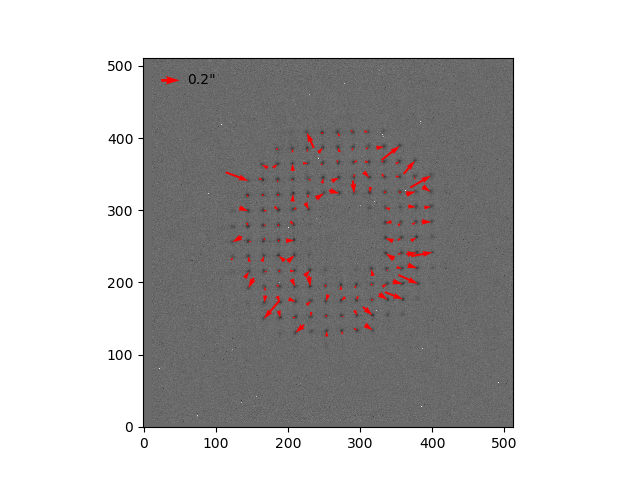

In [17]:
zresults = mmirs.fit_wavefront(results, plot=True)
zv = zresults['raw_zernike']
print(zv)
plt.show()

In [ ]:
from astroscrappy import detect_cosmics

In [ ]:
mask, newim = detect_cosmics(results['data'])

In [ ]:
plt.imshow(results['data']-newim, origin='lower')
plt.show()

In [ ]:
im = results['data']
back = background(im, h=0.7)
subt = im - back

ycen, xcen = 232, 249
n = im.shape[0]
r = 0.5*n
y, x = np.ogrid[-ycen:n-ycen, -xcen:n-xcen]

mask = x**2 + y**2 < r**2
subt[mask] = np.nan

norm = visualization.ImageNormalize(
    subt,
    interval=visualization.ZScaleInterval(),
    stretch=visualization.AsinhStretch()
)
plt.imshow(subt, norm=norm, origin='lower')
plt.show()
s = subt.copy()
np.nanstd(s)

In [ ]:
back_subs = np.where()

# F/9 Dev Section

In [ ]:
f9wfs = WFSFactory(wfs="f9", nzern=20, h=0.99)
f9_file = "/Users/tim/MMT/wfsdat/20170318/TREY_p500_0000.fits"
results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
plt.show()
# 265 258
# ref 240 259.5

In [ ]:
zresults = f9wfs.fit_wavefront(results, plot=True)
print(zresults['zernike'])
plt.show()

In [ ]:
zv = zresults['zernike']
zv.ignore('Z02')
zv.ignore('Z03')
zv.plot_map()
plt.show()

# F/5 Dev Section

In [ ]:
f5wfs = WFSFactory(wfs="f5", nzern=20, back_h=0.99, pup_size=440)
f5_file = "/Users/tim/MMT/wfsdat/20170301/auto_wfs_0037_ave.fits"
results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
plt.show()

In [ ]:
zresults = f5wfs.fit_wavefront(results, plot=True)
zv = zresults['zernike']
print(zv)
plt.show()

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
zv.ignore('Z04')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
zresults['rot_zernike'] - zresults['zernike']

In [ ]:
zv.ignore('Z02')
zv.ignore('Z03')
print(zv.rms)
zv.plot_map()
plt.show()

In [ ]:
pup = f5wfs.pupil_mask(rotator=0)
plt.imshow(pup)
plt.show()

In [ ]:
im = check_wfsdata(f5_file)
back = background(im, h=0.9)
plt.imshow(im-back, origin='lower')
plt.show()

In [ ]:
subt = im - back
fits.writeto("blah.fits", subt, overwrite=True)

# Scratch space

In [ ]:
cen = center_pupil(subt, pup, plot=True)
print(cen)
plt.show()

In [ ]:
from astropy.io import ascii

In [ ]:
t = f9wfs.telescope
m = t.zern_map

In [ ]:
z = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.sub.zrn.cor")
z1 = np.loadtxt("/Users/tim/MMT/wfsdat/20170110/mmirs_wfs_0375.dao.av.zrn")

In [ ]:
z1 - z

In [ ]:
Z = ZernikeVector(coeffs=z, zmap=m)

In [ ]:
Z

In [ ]:
from astropy.table import Table
from astropy.io import ascii

In [ ]:
t = ascii.read("/Users/tim/MMT/mmtwfs/mmtwfs/data/mmirszernfield.tab")

In [ ]:
t

In [ ]:
np.interp(0.12, t['field_r'], t['Z01'])

In [ ]:
range(4, 11)

In [ ]:
for i in range(4, 12):
    print("Z%02d" % i)